<a href="https://colab.research.google.com/github/napsugark/LLM_Course/blob/main/04_LLM_Learning_Path_5_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Agents**


**Description**:
An LLM agent is a system that uses an LLM as it's reasoning agent, as the brain or the CPU, that runs in a loop and based on it's memmory (context window) it can determin actions to be taken on the world (call an api, use the calculator, search) untill it has achived it's goal.

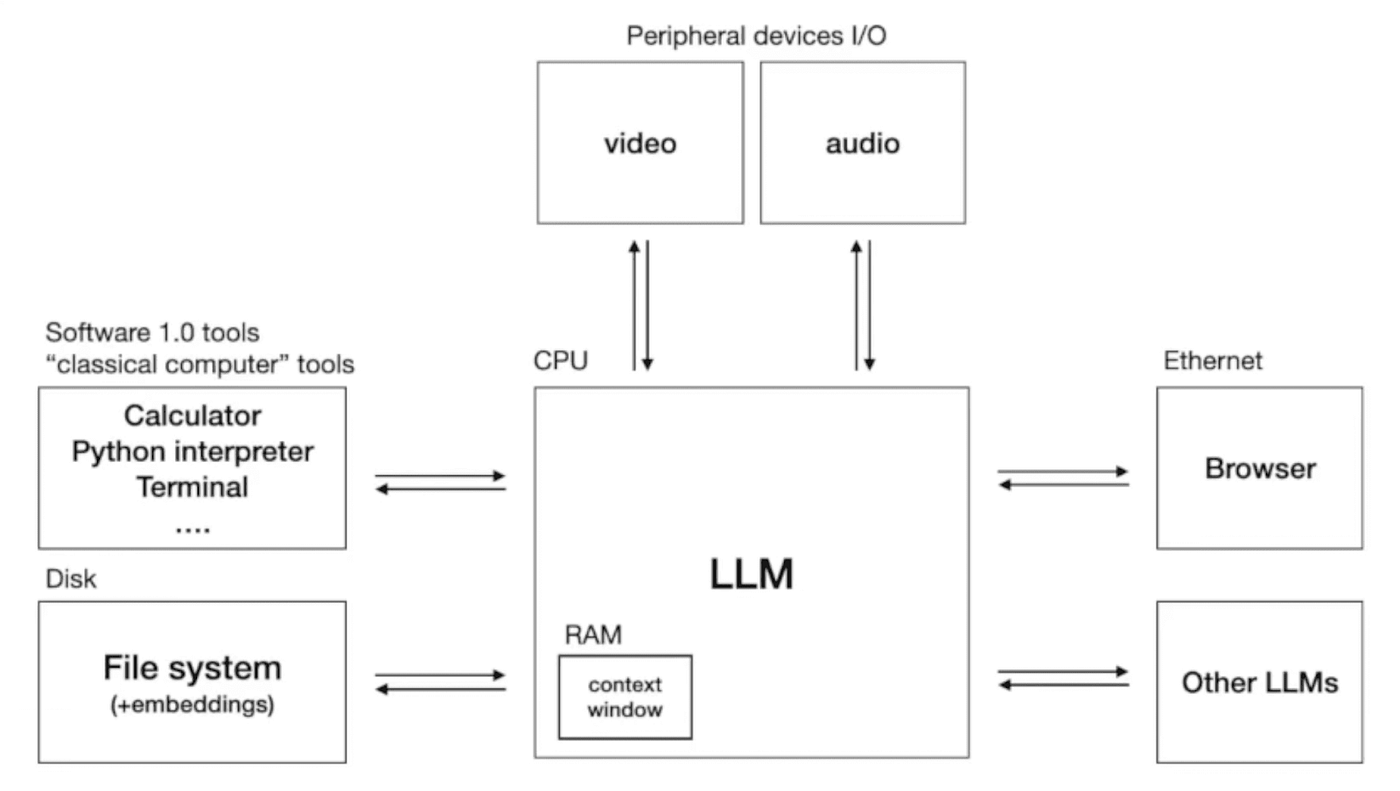

# Concepts to know


* Zero-shot prompting
* Few-shot prompting
* Chain-of-thought
* In-Context learning
* ReAct agents
* Structured outputs
* Function calling



# Learning materials

**Mandatory**



Agent inner-working:
*   https://www.promptingguide.ai/techniques/react
*   https://platform.openai.com/docs/guides/function-calling
*   https://www.promptingguide.ai/research/llm-agents

Building agents:
*   https://www.anthropic.com/research/building-effective-agents


**Optional**

Langgraph:
*   https://langchain-ai.github.io/langgraph/tutorials/introduction/
*   https://academy.langchain.com/courses/intro-to-langgraph

Prompting:
* https://www.promptingguide.ai/techniques/zeroshot
* https://www.promptingguide.ai/techniques/fewshot
* https://www.promptingguide.ai/techniques/cot

Agent architectures:
* https://langchain-ai.github.io/langgraph/tutorials/#agent-architectures
* https://langchain-ai.github.io/langgraph/concepts/multi_agent/

Structured ouptups:
* https://medium.com/towards-data-science/diving-deeper-with-structured-outputs-b4a5d280c208

# [Setup](https://platform.openai.com/docs/quickstart)

In [ ]:
%pip install --upgrade openai tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1


In [ ]:
from google.colab import userdata
import os
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('AZURE_OPENAI_API_KEY')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('AZURE_OPENAI_ENDPOINT')
os.environ["AZURE_OPENAI_EMBEDDINGS_ENDPOINT"] = userdata.get('AZURE_OPENAI_EMBEDDINGS_ENDPOINT')

In [ ]:
from openai import AzureOpenAI

client = AzureOpenAI(
  api_key = os.getenv("AZURE_OPENAI_API_KEY"),
  api_version="2024-08-01-preview",
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"),
)

# [Tools](https://platform.openai.com/docs/guides/function-calling)

Now to make our llm agentic, meaning to have agency, we must equip it with tool, you can think of these tools as functions which the model is aware of and will suggest for us to run it and pass it back the result. This function could be a api call, a search, or a simple python function.

We have this simple function that will take notes for us when we are chatting with the agent.

In [ ]:
def take_note(note: str) -> None:
  print(f"Note taken: {note}")


## **1.   Now that we have our function in our python code, we need to make the llm aware of the existance of the function, so that it knows it can call it.**




We must define our function as a JSON schema following these important steps:

* Where we must specifiy it's name, it must be the same name as our python function


```python
 "name": "take_note",
```


* The function description, where we must specify what this function is, what it is doing, and when should it be called.

```python
"description": "Takes a note",
```

* Then we must describe the parameters of the function along with their type and description, so that the model knows what type of data should be passed to that parameter and what exactly the content of the parameter should be. In our case it would be the parameter named 'note', that is of type string and it should have the value of the note that we want to take

```python
"note": {
            "type": "string",
            "description": "The note to take"
        }
```

* And we can mark parameters as required, if not mentioned, then they are optionl

```python
"required": ["note"]
```

In [ ]:
tool_schema = {
    "type": "function",
    "function": {
        "name": "take_note",
        "description": "Takes a note",
        "parameters": {
            "type": "object",
            "properties": {
                "note": {
                    "type": "string",
                    "description": "The note to take"
                }
            },
            "required": ["note"]
        }
    }
}


## **2.   Now we must give our agent a request that would trigger the tool call**



In [ ]:
messages = [
    {
      "role": "user",
      "content": "Take a note to buy milk."
    },
]

In the openAI client we must make it aware of our tool's existance by passing it to the tools parameter



```python
tools=[tool_schema],
```



In [ ]:
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    tools=[tool_schema],
    tool_choice="auto"
)

In [ ]:
completion.choices[0].message

ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_Ylj96eG39ec0F9fOu9dOi7bb', function=Function(arguments='{"note":"Buy milk."}', name='take_note'), type='function')])

And after the call, we get back a message with the assistant role, that we see, it doesnt have any content, but it has a tool call



```
tool_calls=[ChatCompletionMessageToolCall(id='call_k3xJDBscad8zG457tGMOX5id', function=Function(arguments='{"note":"Buy milk"}', name='take_note'), type='function')]
```





## **3.   We must append that message to the list of messages so the LLM knows it wanted to call that toole**




In [ ]:
messages.append(completion.choices[0].message)

In [ ]:
completion.choices[0].message.tool_calls

[ChatCompletionMessageToolCall(id='call_Ylj96eG39ec0F9fOu9dOi7bb', function=Function(arguments='{"note":"Buy milk."}', name='take_note'), type='function')]

Now if we break down that we can see that it tells us to call a function with the name 'take_note', and we must pass the the parameter named 'note', the value 'Buy milk'

In [ ]:
assistant_tool_message = {
    "role": completion.choices[0].message.role,
    "content": completion.choices[0].message.content,
    "tool_call": {
        "id": completion.choices[0].message.tool_calls[0].id,
        "type": completion.choices[0].message.tool_calls[0].type,
        "function": {
            "name": completion.choices[0].message.tool_calls[0].function.name,
            "arguments": completion.choices[0].message.tool_calls[0].function.arguments
        }
    }
}
assistant_tool_message

{'role': 'assistant',
 'content': None,
 'tool_call': {'id': 'call_Ylj96eG39ec0F9fOu9dOi7bb',
  'type': 'function',
  'function': {'name': 'take_note', 'arguments': '{"note":"Buy milk."}'}}}



## **4.   We take the suggestion from the llm on which tool to call, and with wich parameters and call it in our python code**



In [ ]:
import json
if assistant_tool_message["tool_call"]["function"]["name"] == "take_note":
  arguments = assistant_tool_message["tool_call"]["function"]["arguments"]
  arguments = json.loads(arguments)
  note = arguments["note"]
  take_note(note)

Note taken: Buy milk.


## **5. After we call the function, the LLM expects back the result of the tool, in cases where the tool is a search tool, we would give back the result of the search. In our case, we just say that the note was saved.**



```
{
    "note_saved": True,
}
```



In [ ]:
function_call_result_message = {
  "role": "tool",
  "content": json.dumps({
      "note_saved": True,
  }),
  "tool_call_id": assistant_tool_message["tool_call"]["id"]
}
function_call_result_message

{'role': 'tool',
 'content': '{"note_saved": true}',
 'tool_call_id': 'call_Ylj96eG39ec0F9fOu9dOi7bb'}

## **6. We append that to the list of messages as well so that the LLM is aware of the result of the function**

In [ ]:
messages.append(function_call_result_message)

## **7. And we give the whole list of messages so that the LLM could respond based on the results of the tool call. And as you can see, it confirms that the note was taken**

In [ ]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages
)
response.choices[0].message

ChatCompletionMessage(content="I've saved a note for you to buy milk.", refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)

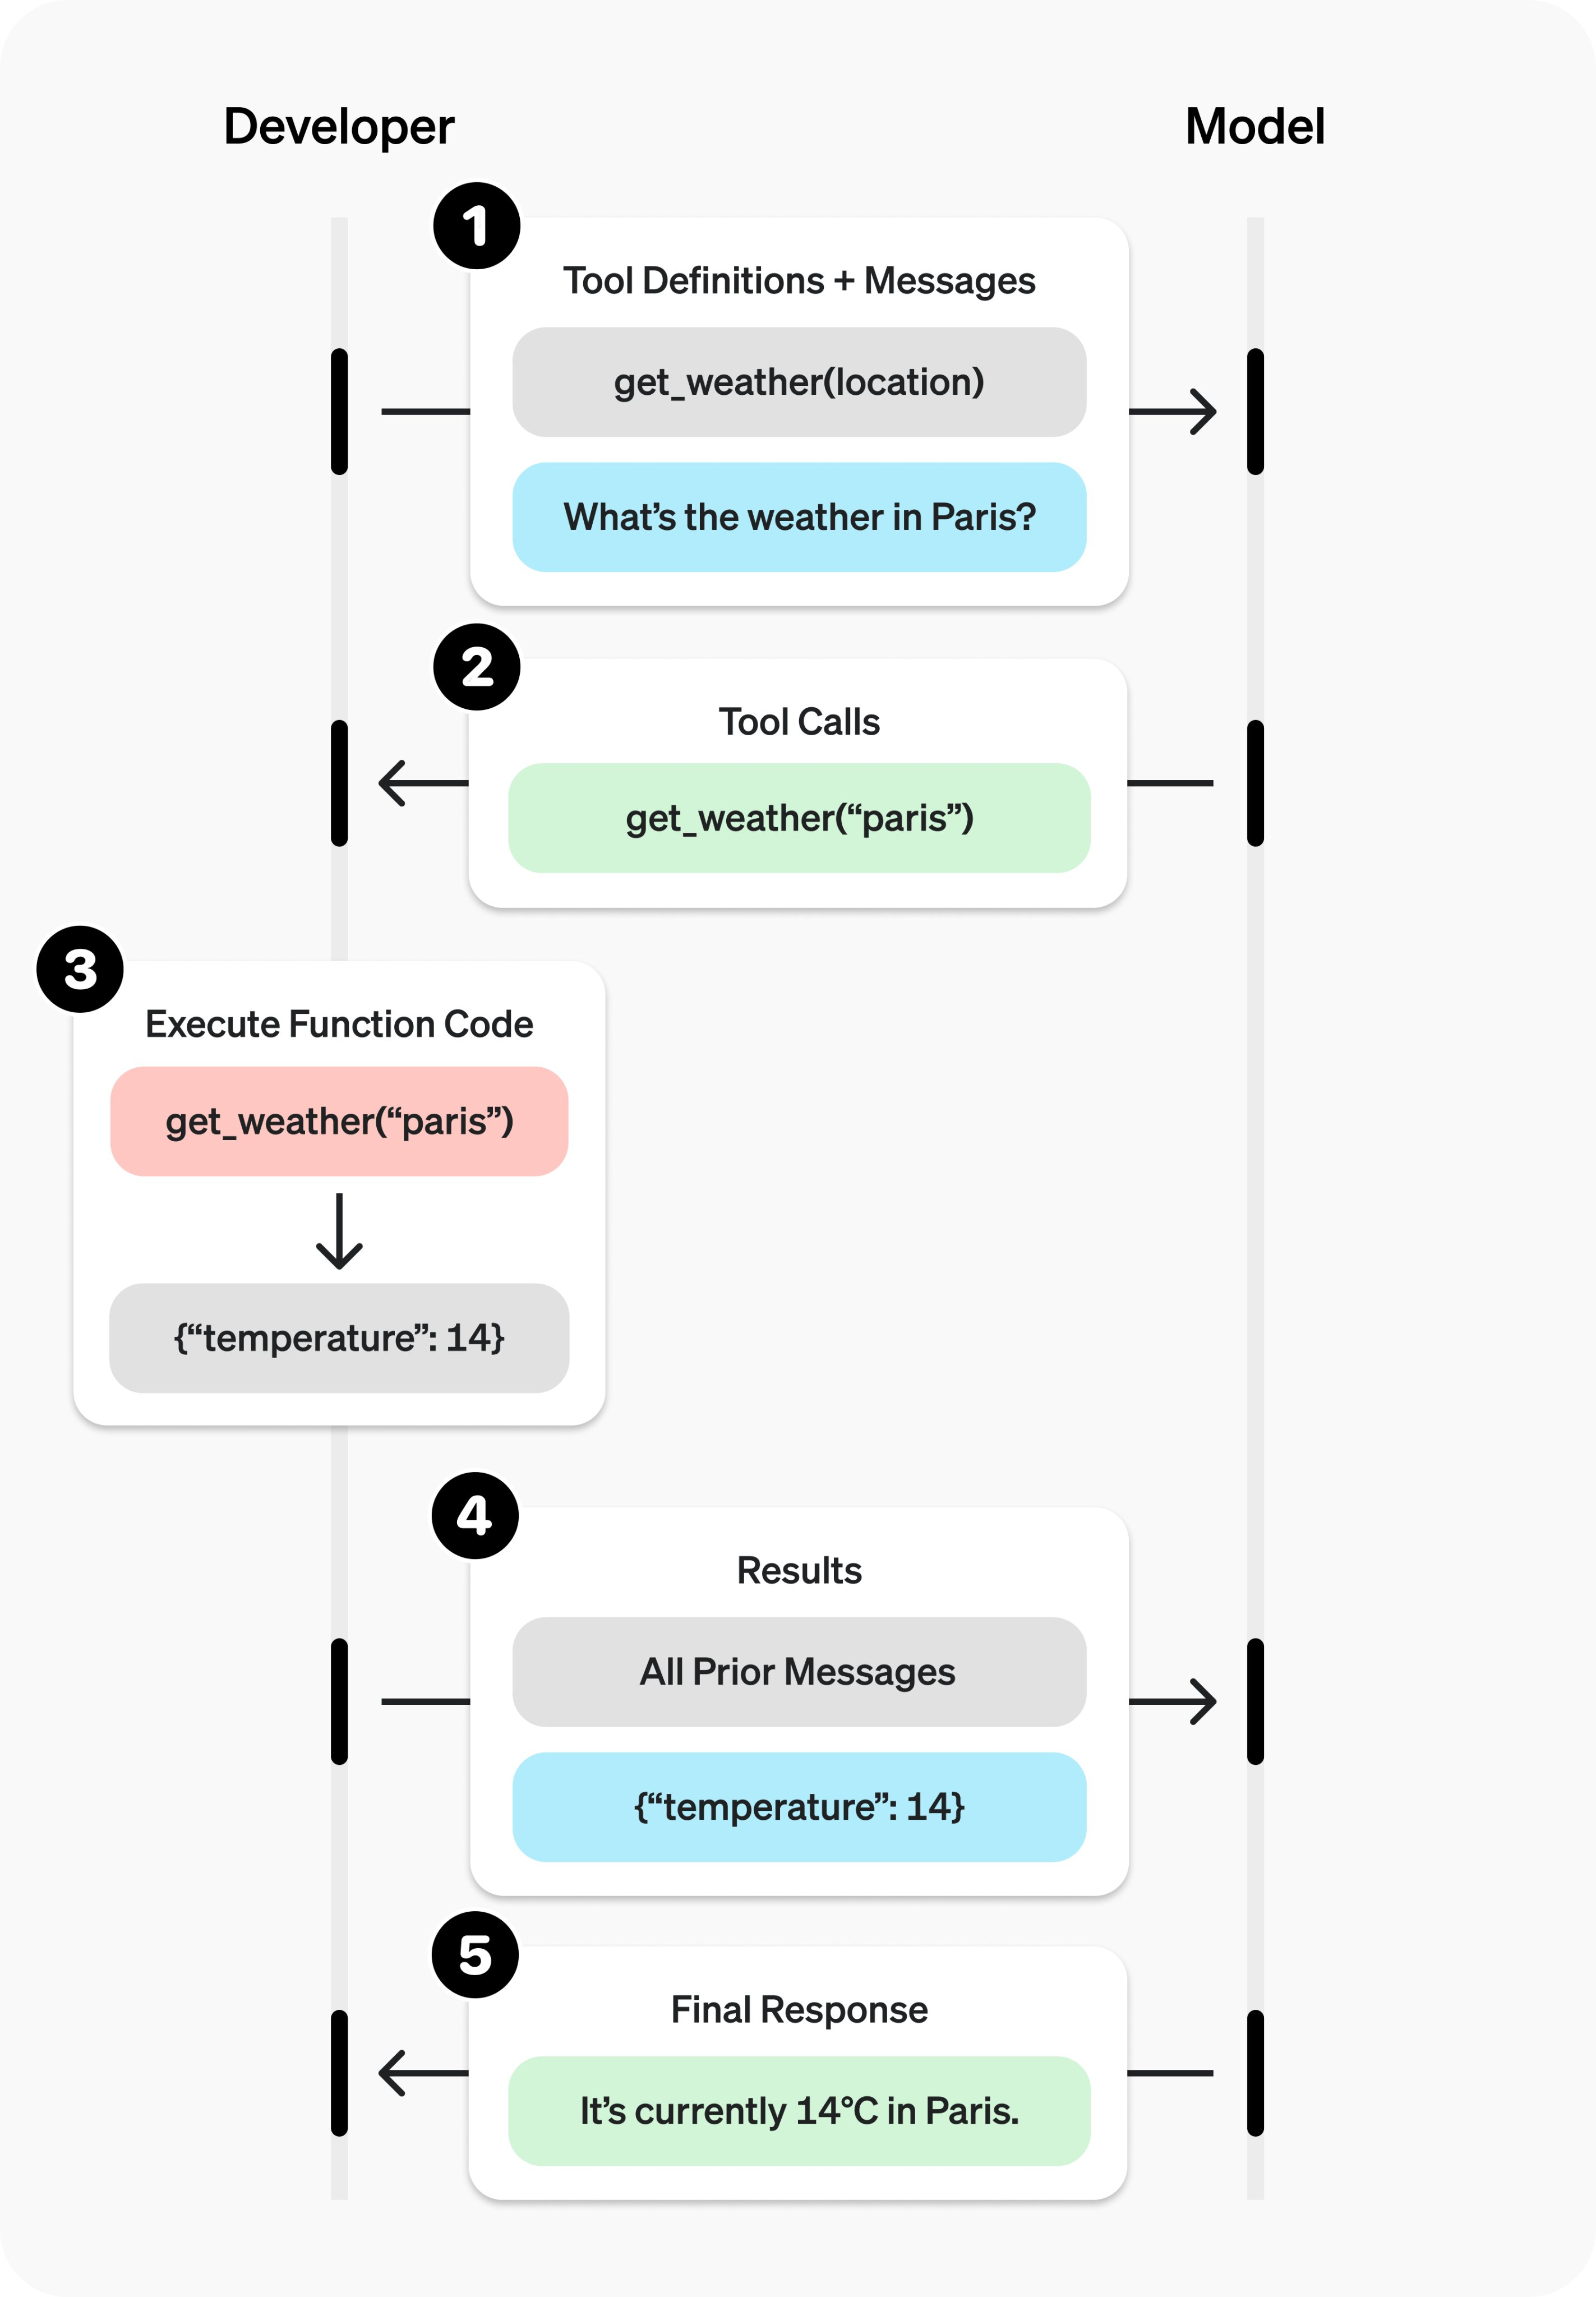

## Assignment: using the previous implementation, try to ask it questions that would not trigger the function call, for example 'What is the capilat of France?'.

## Assignment: Create a tool that remembers things from the conversation and have it triggered when the user says something personal, like it's name or birth date.

# Structured output

In [ ]:
from pydantic import BaseModel

class CalendarEvent(BaseModel):
    name: str
    date: str
    participants: list[str]

completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {"role": "user", "content": "Alice and Bob are going to a science fair on Friday."},
    ],
    response_format=CalendarEvent,
)

event = completion.choices[0].message.parsed

In [ ]:
event

CalendarEvent(name='Science Fair', date='Friday', participants=['Alice', 'Bob'])

In [ ]:
event.date

'Friday'

In [ ]:
class Step(BaseModel):
    explanation: str
    output: str

class MathReasoning(BaseModel):
    steps: list[Step]
    final_answer: str

completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful math tutor. Guide the user through the solution step by step."},
        {"role": "user", "content": "how can I solve 8x + 7 = -23"}
    ],
    response_format=MathReasoning,
)

math_reasoning = completion.choices[0].message.parsed

In [ ]:
math_reasoning

MathReasoning(steps=[Step(explanation='We start with the equation 8x + 7 = -23. The goal is to isolate the variable x. First, we need to get rid of the constant on the left side, which is +7. We can do this by subtracting 7 from both sides of the equation.', output='8x + 7 - 7 = -23 - 7'), Step(explanation='Now, simplifying both sides gives us 8x = -30. We have successfully isolated the term with x on one side.', output='8x = -30'), Step(explanation='Next, we need to solve for x by dividing both sides of the equation by 8. This will help us find the value of x.', output='x = -30 / 8'), Step(explanation='Finally, we simplify the fraction -30 / 8. Dividing both the numerator and the denominator by 2 gives us -15 / 4. Thus, x can be expressed as -15/4 (or -3.75 in decimal form).', output='x = -15/4 or x = -3.75')], final_answer='x = -15/4 or x = -3.75')

In [ ]:
for step in math_reasoning.steps:
    print(step.explanation)
    print(step.output)

We start with the equation 8x + 7 = -23. The goal is to isolate the variable x. First, we need to get rid of the constant on the left side, which is +7. We can do this by subtracting 7 from both sides of the equation.
8x + 7 - 7 = -23 - 7
Now, simplifying both sides gives us 8x = -30. We have successfully isolated the term with x on one side.
8x = -30
Next, we need to solve for x by dividing both sides of the equation by 8. This will help us find the value of x.
x = -30 / 8
Finally, we simplify the fraction -30 / 8. Dividing both the numerator and the denominator by 2 gives us -15 / 4. Thus, x can be expressed as -15/4 (or -3.75 in decimal form).
x = -15/4 or x = -3.75


## Assignment: using the structured output mechanism, create a router, that based on a query you could redirect the user based on a list of topics (this could be used to route to multiple agents)

# Rag refresher



In [ ]:
import os
import pandas as pd
import numpy as np
from openai import AzureOpenAI

#############################################################################
# 1. Initialize the AzureOpenAI client
#############################################################################
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),         # or a string directly
    api_version="2024-08-01-preview",                  # or whichever version your Azure portal indicates
    azure_endpoint=os.getenv("AZURE_OPENAI_EMBEDDINGS_ENDPOINT")  # e.g. "https://<your-resource>.openai.azure.com/"
)

#############################################################################
# 2. Example DataFrame with some text columns
#############################################################################
data = {
    "text": [
        "The cats are an alien species",
        "It's been raining heavily all day, making it gloomy and unsuitable for outdoor plans.",
        "Do you prefer rainy days or sunny weather for your outdoor activities?"
    ]
}
df = pd.DataFrame(data)

#############################################################################
# 3. Helper function to fetch embeddings from Azure OpenAI
#    Make sure 'deployment_id' matches your embeddings deployment name.
#############################################################################
def get_embedding(text, model="text-embedding-ada-002"):
    # Ensure the input is a list of strings (even if just 1 string)
    response = client.embeddings.create(
        input=[text.replace("\n", " ")],
        model=model
    )
    # Extract the embedding from the response
    return response.data[0].embedding

#############################################################################
# 4. Precompute and store embeddings in the DataFrame
#############################################################################
embeddings = []
for txt in df["text"]:
    emb = get_embedding(txt, model="text-embedding-ada-002")
    embeddings.append(emb)

df["embedding"] = embeddings

#############################################################################
# 5. Define a cosine similarity function
#############################################################################
def cosine_similarity(a, b):
    a = np.array(a, dtype=np.float32)
    b = np.array(b, dtype=np.float32)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

#############################################################################
# 6. Define a search function using the embeddings
#############################################################################
def search_documents(df, prompt, model="text-embedding-ada-002", n=3):
    prompt_emb = get_embedding(prompt, model)
    similarities = []
    for emb in df["embedding"]:
        sim = cosine_similarity(emb, prompt_emb)
        similarities.append(sim)

    # Add the similarity scores to the DataFrame
    df["similarities"] = similarities

    # Sort rows in descending order of similarity and return the top n
    results = df.sort_values("similarities", ascending=False).head(n)
    return results

#############################################################################
# 7. Test query
#############################################################################
query = "what do you know about cats?"
result = search_documents(df, query, model="text-embedding-ada-002", n=3)
print(result)


                                                text  \
0                      The cats are an alien species   
2  Do you prefer rainy days or sunny weather for ...   
1  It's been raining heavily all day, making it g...   

                                           embedding  similarities  
0  [0.014195105992257595, -0.012247877195477486, ...      0.863498  
2  [0.013638314791023731, 0.005661367904394865, 0...      0.756388  
1  [-0.006208834238350391, -0.015362467616796494,...      0.709938  


In [ ]:
import numpy as np

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   emb = client.embeddings.create(input = text, model=model)
   print(emb)
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def search_documents(df, prompt, n=3, pprint=True):
   embedding = get_embedding(prompt, model='text-embedding-ada-002')
   df['similarities'] = df.embedding.apply(lambda x: cosine_similarity(x, embedding))
   res = df.sort_values('similarities', ascending=False).head(n)
   return res

res = search_documents(df, 'what do you know about cats?', n=3)
res

BadRequestError: Unsupported data type

In [ ]:
def answer_question(df, prompt, k, top_k, model="gpt-4o-mini"):
  documents = search_documents(df, prompt, n=k)
  context = "\n\n###\n\n".join(documents['text'].head(top_k))
  messages = [
      {
          "role": "system",
          "content": f"""
          You are a helpful assistant that answers questions about the following context.
          Answer shortly.
          <context>
            {context}
          </context>
          """
      },
      {
          "role": "user",
          "content": prompt
      }
  ]

  completion = client.chat.completions.create(
      model=model,
      messages=messages
  )
  return completion.choices[0].message.content

In [ ]:
answer = answer_question(df, 'what do you know about cats?', 3, 1)
answer

In [ ]:
def retriever(df, prompt, k=3, top_k=1):
  documents = search_documents(df, prompt, n=k)
  context = "\n\n###\n\n".join(documents['text'].head(top_k))
  return context

# Agents

## Let's put it all together. We have our agent class that can recieve a knowledge base, answer questions about it and take notes
Our agent has the following:
* all the parameters we need (model names, chunking and retrieval hyperparameters)
* storage:
 * our message list which can be thought of as short term memmory
 * our dataframe where we store the chunks for vector search (long term memmory)
 * our notes
 * the tools it knows of (in JSON schema format)
 * the methods of the class (`store` for the storing of the internal knowledge, `get_embeddings`(just gets embeddings), `search_documents`(searches for similar documents), `retrieve_context`(formats focuments after search))
 * the tool handler which will select the tools of the class based on the response from the LLM

In [ ]:
# Import necessary libraries
from typing import List, Dict, Union
import pandas as pd
import numpy as np
import json
from typing import List, Dict, Union
import tiktoken
from openai import OpenAI

import tiktoken

def get_tokens(string: str, encoding_name: str):
    encoding = tiktoken.get_encoding(encoding_name)
    tokens = encoding.encode(string)
    return tokens

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    tokens = get_tokens(string, encoding_name)
    return len(tokens)

get_tokens("tiktoken is great!", "cl100k_base")
num_tokens_from_string("tiktoken is great!", "cl100k_base")

class Agent:
    def __init__(
        self,
        model: str = "gpt-4",
        embedding_model: str = "text-embedding-ada-002",
        top_k: int = 1,
        chunk_size: int = 200
    ):
        # Initialize OpenAI client and model settings
        self.client = AzureOpenAI(
          api_key = os.getenv("AZURE_OPENAI_API_KEY"),
          api_version="2024-08-01-preview",
          azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"),
        )
        self.embedding_client = client = AzureOpenAI(
            api_key=os.getenv("AZURE_OPENAI_API_KEY"),         # or a string directly
            api_version="2024-08-01-preview",                  # or whichever version your Azure portal indicates
            azure_endpoint=os.getenv("AZURE_OPENAI_EMBEDDINGS_ENDPOINT")  # e.g. "https://<your-resource>.openai.azure.com/"
        )
        self.model = model
        self.embedding_model = embedding_model
        self.top_k = top_k
        self.chunk_size = chunk_size

        # Initialize storage containers
        self.messages = []
        self.df = pd.DataFrame(columns=['id', 'text', 'embedding'])
        self.notes = []

        # Define available tools/functions that can be called by the model
        self.tools = [
            {
                "type": "function",
                "function": {
                    "name": "take_note",
                    "description": "Takes a note and stores it",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "note": {
                                "type": "string",
                                "description": "The note to take"
                            }
                        },
                        "required": ["note"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "retrieve_context",
                    "description": "Retrieves relevant context based on a query",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "query": {
                                "type": "string",
                                "description": "The query to search for relevant context"
                            }
                        },
                        "required": ["query"]
                    }
                }
            }
        ]

    def store(self, text: str, chunk_size: int = 500) -> str:
        """Store text by breaking it into chunks and embedding each chunk"""
        chunks = []
        current_chunk = ""
        # Split text into sentences
        sentences = text.replace('\n', '. ').split('. ')

        # Process each sentence
        for sentence in sentences:
            if not sentence.strip():
                continue

            # Try to add sentence to current chunk
            potential_chunk = current_chunk + ". " + sentence if current_chunk else sentence
            tokens = num_tokens_from_string(potential_chunk, "cl100k_base")

            # If chunk is within token limit, add sentence
            if tokens <= 500:
                current_chunk = potential_chunk
            else:
                # If chunk would exceed limit, store current and start new chunk
                if current_chunk:
                    chunks.append(current_chunk)
                current_chunk = sentence

        # Store final chunk if it exists
        if current_chunk:
            chunks.append(current_chunk)

        # Create embeddings for each chunk and store in dataframe
        for chunk in chunks:
            embedding = get_embedding(chunk, model=self.embedding_model)
            self.df = pd.concat([self.df, pd.DataFrame({'id': [len(self.df)], 'text': [chunk], 'embedding': [embedding]})], ignore_index=True)

        return f"Text stored successfully: {text[:100]}... {len(chunks)} chunks"

    def take_note(self, note: str) -> str:
        """Store a note in the agent's knowledge base."""
        self.notes.append(note)
        return f"Note stored successfully: {note[:100]}..."

    def get_embedding(self, text):
        """Get embedding for a piece of text using OpenAI's API"""
        text = text.replace("\n", " ")
        return self.embedding_client.embeddings.create(input = [text], model=self.embedding_model).data[0].embedding

    def search_documents(self, prompt, n=3):
        """Search stored documents using similarity to prompt"""
        # Get embedding for search prompt
        embedding = self.get_embedding(prompt)
        # Calculate similarities between prompt and stored documents
        self.df['similarities'] = self.df.embedding.apply(lambda x: cosine_similarity(x, embedding))
        # Return top n most similar documents
        res = self.df.sort_values('similarities', ascending=False).head(n)
        return res

    def retrieve_context(self, query: str) -> str:
        """Retrieve relevant context based on query."""
        # Search for relevant documents
        documents = self.search_documents(query)
        # Join top k documents with separator
        context = "\n\n###\n\n".join(documents['text'].head(self.top_k))
        return context

    def tools_handler(self, messages: List[any]) -> Union[str, List[any]]:
        """Handle tool calls from the model's response"""
        # If no tool calls, return the message content directly
        if not messages[-1].tool_calls:
            return messages[-1].content

        tool_calls = messages[-1].tool_calls
        response_messages = [messages[-1]]

        # Process each tool call
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_args = json.loads(tool_call.function.arguments)

            # Execute the appropriate function
            if function_name == "take_note":
                result = self.take_note(function_args["note"])
            elif function_name == "retrieve_context":
                result = self.retrieve_context(function_args["query"])

            # Create message with tool results
            tool_message = {
                "role": "tool",
                "tool_call_id": tool_call.id,
                "name": function_name,
                "content": result
            }
            messages.append(tool_message)
            response_messages.append(tool_message)

        # Get final response from model after tool usage
        final_completion = self.client.chat.completions.create(
            model=self.model,
            messages=messages
        )
        response_messages.append(final_completion.choices[0].message)
        return response_messages


    def call(self, messages: List[any]) -> Union[str, List[any]]:
        """Process messages and return response, using tools if specified."""
        # Get initial completion from model
        completion = self.client.chat.completions.create(
            model=self.model,
            messages=messages,
            tools=self.tools,
            tool_choice="auto"
        )

        # Add model's response to messages
        messages.append(completion.choices[0].message)
        # Handle any tool calls in the response
        return self.tools_handler(messages)

In [ ]:
agent = Agent(
        model="gpt-4o-mini",
        top_k=2,
        embedding_model="text-embedding-ada-002",
        chunk_size=500)

In [ ]:
initial_knowledge = """
    Artificial Intelligence is a broad field of computer science focused on creating smart machines.
    Machine Learning is a subset of AI that uses data to learn and improve performance.
    Deep Learning is a type of machine learning using neural networks with multiple layers.
    """

In [ ]:
agent.store(initial_knowledge)

'Text stored successfully: \n    Artificial Intelligence is a broad field of computer science focused on creating smart machines... 1 chunks'

In [ ]:
def print_tool_interaction(response_list):
    """Pretty print the tool interaction from the response list"""
    print("\n=== Tool Usage ===")

    for item in response_list:
        # Handle ChatCompletionMessage with tool calls
        if hasattr(item, 'tool_calls') and item.tool_calls:
            for tool_call in item.tool_calls:
                print(f"\nTool Called: {tool_call.function.name}")
                print(f"Parameters: {tool_call.function.arguments}")

        # Handle tool response
        elif isinstance(item, dict) and item.get('role') == 'tool':
            print(f"\nTool Result: {item['content']}")
            print("\n===============")

        # Handle final assistant response
        elif hasattr(item, 'content') and item.content:
            print(f"\nFinal Response: {item.content}")


In [ ]:
messages = []
print("\nChat started! (Type 'quit' to exit)")
print("-" * 50)

while True:
    # Get user input
    user_input = input("\nYou: ")
    print("-" * 50)

    # Check for quit command
    if user_input.lower() in ['quit', 'exit', 'bye']:
        print("\nGoodbye!")
        break

    # Add user message to history
    messages.append({"role": "user", "content": user_input})

    try:
        # Get response from agent
        response = agent.call(messages)

        # If response is a string, print it directly
        if isinstance(response, str):
            print("\nAssistant:", response)
            messages.append({"role": "assistant", "content": response})
        # If response is a list (tool usage), print the final message
        else:
            print_tool_interaction(response)
            messages.extend(response)

    except Exception as e:
        print(f"\nError: {str(e)}")
        continue

    print("-" * 50)


Chat started! (Type 'quit' to exit)
--------------------------------------------------

You: Hello there
--------------------------------------------------

Assistant: Hello! How can I assist you today?
--------------------------------------------------

You: my name is andrew
--------------------------------------------------

Assistant: Nice to meet you, Andrew! How can I help you today?
--------------------------------------------------

You: make a note of thiis
--------------------------------------------------

=== Tool Usage ===

Tool Called: take_note
Parameters: {"note":"User's name is Andrew."}

Tool Result: Note stored successfully: User's name is Andrew....


Final Response: I've made a note that your name is Andrew. What else would you like to do?
--------------------------------------------------

You: q
--------------------------------------------------

Assistant: It seems like your message was incomplete. Could you please provide more details or clarify what you need?

## Assignment: using the previous code create a function that displays all the notes and improve the descriptions of the tool
Bonus: find a way to integrate a system prompt message which the user cannot change

# Langgraph way


In [ ]:
%pip install langgraph langchain-openai langchain-chroma langchain-community langchain_text_splitters

We still have our initial knowledge


In [ ]:

initial_knowledge = """
    Artificial Intelligence is a broad field of computer science focused on creating smart machines.
    Machine Learning is a subset of AI that uses data to learn and improve performance.
    Deep Learning is a type of machine learning using neural networks with multiple layers.
    """


We must split it

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=100,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
documents = text_splitter.create_documents([initial_knowledge])
print(documents[0])
print(documents[1])

page_content='Artificial Intelligence is a broad field of computer science focused on creating smart'
page_content='on creating smart machines.'


Then save it into our vector store

In [ ]:
from langchain_openai import AzureOpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from uuid import uuid4

embeddings = AzureOpenAIEmbeddings(model="text-embedding-ada-002", api_key=os.getenv("AZURE_OPENAI_API_KEY"), azure_endpoint=os.getenv("AZURE_OPENAI_EMBEDDINGS_ENDPOINT"))

vector_store = Chroma(
    collection_name="study_collection",
    embedding_function=embeddings,
)

uuids = [str(uuid4()) for _ in range(len(documents))]

vector_store.add_documents(documents=documents, ids=uuids)

['122013e6-6d5d-4403-9628-422a035a81ce',
 '5bb2785d-9e58-4cd3-bfd2-7af265a7d5e0',
 'fe33aa5f-577b-4bb8-9d66-947544515ca5',
 '5b393c45-b5b1-4811-acf8-aa7cbeb3cda5']

Improvize a local note storage (you could use anything really)

In [ ]:
from langchain_core.stores import InMemoryStore

in_memory_store = InMemoryStore()
id = str(uuid4())
in_memory_store.mset([(id, "note")])


In [ ]:
in_memory_store.mget([id])

['note']

Now lets see how easy it is to create our tools (using the @tool decorator will use the docstring and the parameter type to create the json schema for the tool)

In [ ]:
from langchain_core.tools import tool

@tool
def search(query: str) -> str:
    """Search for documents based on a query."""
    results = vector_store.similarity_search(
        "query",
        k=2,
        #filter={"source": "tweet"},
    )
    return results

@tool
def take_note(note: str) -> str:
    """Take a note and store it."""
    id = str(uuid4())
    in_memory_store.mset([(id, note)])
    return f"Note stored successfully: {note[:100]}..."
    return

Now we will use langgraph, and we will implement the necessary functions, so we can see what is abstracted away

In [ ]:
from typing import Annotated

from langchain_openai import AzureChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


#---------The class State will be used to keep the state of the graph as we pass from node to node during the execution (think of it as a state machine)---------

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

#---------Create the graph with the state---------

graph_builder = StateGraph(State)

#---------Create our list of tools---------

tools = [search, take_note]

#---------Define the llm---------

llm = AzureChatOpenAI(
    model="gpt-4o-mini",
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-08-01-preview")

#---------Bind the tools to the llm. Make the llm aware of the existence of the tools (this will attatch the json schema of each tool to the prompt of the llm)---------

llm_with_tools = llm.bind_tools(tools)

#---------Define the function that will be called when we reach the chatbot node. This will call the llm and append whatever message we recieve to the message list of the state, so we have access to it in other nodes.---------

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

#---------Add the node with the name "chatbot" that will call the function chatbot---------

graph_builder.add_node("chatbot", chatbot)

import json

from langchain_core.messages import ToolMessage

#---------Now we need to define a node that will call the tool based on which tool and with which parameter the llm told us to in it's last message---------

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

#---------Create the node based on the BasicToolNode class and this node also needs to be aware of the functions that it will call---------

tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

#---------Now we need a routing logic, if the last message from the chatbot node is a simple message then we can go to the end of the graph executin.---------
#---------If the last message contains a tool call, then we must go to the BasicToolNode to call those functions in python and return the result to the llm so it knows what to do next---------

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

#---------Creating a conditional edge  based on the mentioned above logic---------

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

#---------Add the entry point into the graph---------

graph_builder.add_edge(START, "chatbot")

#---------"Compoile" the graph so that it can be executed---------

graph = graph_builder.compile()

Lets see how it looks

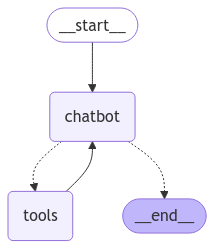

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can do the same thing with less code, using pre-built functions

In [ ]:
from typing import Annotated

from langchain_openai import AzureChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# or we could use from langgraph.graph.message import MessagesState instead of State
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tools = [search, take_note]
llm = AzureChatOpenAI(
    model="gpt-4o-mini",
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-08-01-preview")

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [ ]:
graph = graph_builder.compile()

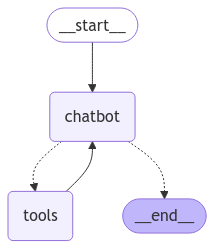

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input = "What is an agent?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is an agent?
================================== Ai Message ==================================
Tool Calls:
  search (call_XhPeq8AQbqGy6JrI4impXeru)
 Call ID: call_XhPeq8AQbqGy6JrI4impXeru
  Args:
    query: What is an agent?
================================= Tool Message =================================
Name: search

[Document(id='5bb2785d-9e58-4cd3-bfd2-7af265a7d5e0', metadata={}, page_content='on creating smart machines.'), Document(id='fe33aa5f-577b-4bb8-9d66-947544515ca5', metadata={}, page_content='Machine Learning is a subset of AI that uses data to learn and improve performance.')]
================================== Ai Message ==================================

An agent generally refers to an entity that has the ability to act upon its environment based on certain inputs or conditions. In various contexts, the term can take on specific meanings:

1. **In Artificial Intelligence (AI)**: An age

Or with even less code if you want

In [ ]:
from langgraph.prebuilt import create_react_agent

model = AzureChatOpenAI(
    model="gpt-4o-mini",
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-08-01-preview")

tools = [search, take_note]

graph = create_react_agent(model, tools=tools)

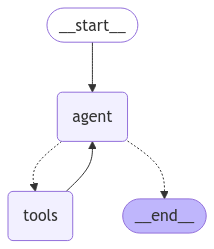

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
user_input = "What is an agent?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is an agent?
================================== Ai Message ==================================
Tool Calls:
  search (call_Fb33pnxS4VbyVmCTdtHuhcVp)
 Call ID: call_Fb33pnxS4VbyVmCTdtHuhcVp
  Args:
    query: What is an agent?
================================= Tool Message =================================
Name: search

[Document(id='5bb2785d-9e58-4cd3-bfd2-7af265a7d5e0', metadata={}, page_content='on creating smart machines.'), Document(id='fe33aa5f-577b-4bb8-9d66-947544515ca5', metadata={}, page_content='Machine Learning is a subset of AI that uses data to learn and improve performance.')]
================================== Ai Message ==================================

An "agent" generally refers to an entity that acts or has the capacity to act. In various contexts, it can mean different things:

1. **In Artificial Intelligence**: An agent is an autonomous entity that observes its environment throug

# Exercises

## Create a RAG agent that looks for movies recomandations in a database and if the user likes it, the agent can save it to a watch list

Bonus: have the agent remember your prefferences

In [ ]:
# happy coding